### demonstrating camera calibration  20221223 CJH
* making the entire list of activities from the opencv docs on camera calibration
* https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html


#### import the necessary libraries

In [77]:
import cv2  # image acquisition and manipulation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob

#### get images from camera  - can be webcam or external USB
* change the usb_index from 0 to something else if you have more than one camera
* loop through images - try to get a dozen before you quit, kicks you out at 16
  * press d for next / delete (don't save)
  * s for save the current image
  * q for quit


In [37]:
usb_index = 0

images = []  # list of images to save
chess_images = []  # list of images to view 

# open the camera and loop through at least 12 calibration images
cam = cv2.VideoCapture(usb_index, cv2.CAP_DSHOW)  # open a regular USB cam

# criteria for finding the chessboard
target_pattern = (9,6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

count = 0
while count < 17:
    s, image_raw = cam.read()  # read from the camera
    if s > 0:  # test if the camera actually returned a success        
    
        # initial checkerboard test - copied from 
        gray = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, target_pattern, None)
         # If found, add object points, image points (after refining them)
        if ret == True:
            corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            # Draw and display the corners
            chess_overlay = cv2.drawChessboardCorners(image_raw.copy(), (9,6), corners2, ret)
            cv2.imshow(f'Image Processing Pipeline', chess_overlay)
        else:
            cv2.imshow(f'Image Processing Pipeline', image_raw)
        
    # close video display on key press
    k = cv2.waitKey(0)
    if k == ord('d'):
        pass
    elif k == ord('s'):
        count = count + 1
        print(f'appending image {count:2d} of at least 12...', end = '\r')
        images.append(image_raw)
        chess_images.append(chess_overlay)
    elif k == ord('q'):
        break  # we're done
    else: 
        pass
    
cam.release()
cv2.destroyAllWindows()

#### view the images, make sure we're happy

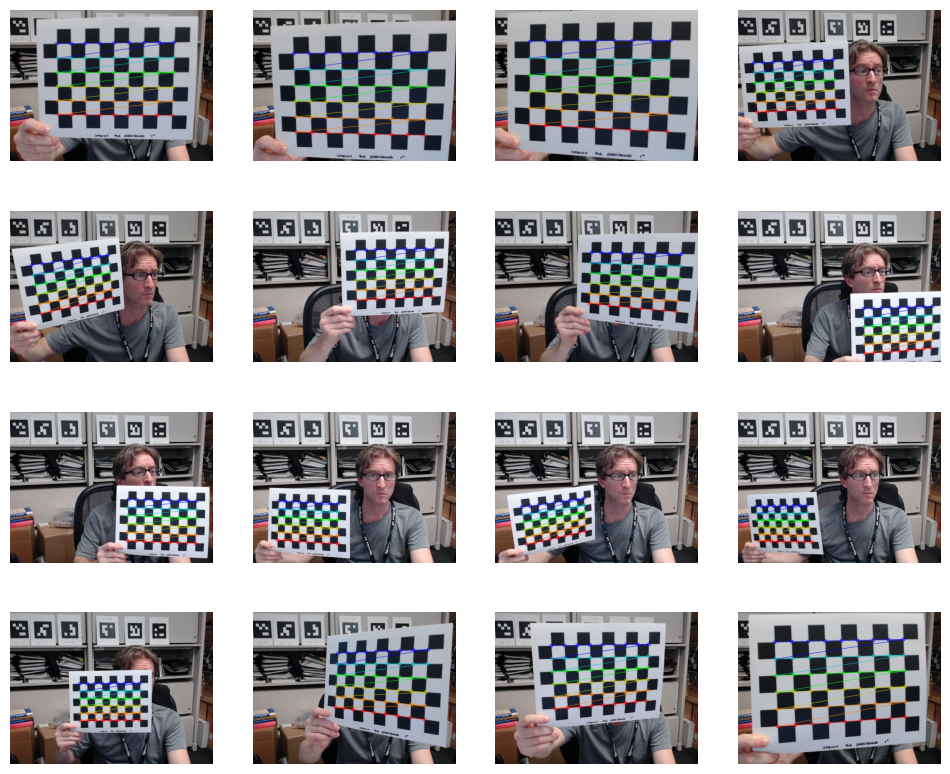

In [38]:
# quickly show the results of the ones we saved
cols = 4
rows = count//4 + int(count%4 > 0) 
fig, axs = plt.subplots(rows, cols, figsize =(12,10))
for idx, ax in enumerate(axs.flatten()[0:count]):
    ax.imshow(cv2.cvtColor(chess_images[idx], cv2.COLOR_BGR2RGB))
    ax.set_axis_off()
for idx, ax in enumerate(axs.flatten()[count:]):
    ax.axis('off')

#### save the images to a folder if you like them enough to generate a camera model

In [62]:
# change to true if you want to save them for analysis later
# todo - make this a more robust method
camera = 'logitech_c920'  # name your camera
camera_dir = cal_images / camera

save_images = False
if save_images:
    import os
    cal_images = Path('.').absolute() / 'cal_images'
    if not cal_images.is_dir():
        os.mkdir(cal_images)    
    try: 
        os.mkdir(camera_dir) 
    except OSError as error: 
        print(f'Likely directory exists - overwriting images! : {error}')
    for idx, im in enumerate(images):
        filepath = camera_dir / f'{camera}_cal_image_{idx}.jpg'
        cv2.imwrite(str(filepath), images[idx])

####  The images are saved, now load and process
* if images are in memory, could use them
* but I'll default to loading from the disk, so save them above

In [75]:
camera = 'logitech_c920'  # name your camera
camera_dir = cal_images / camera
images = glob.glob(str(camera_dir / '*.jpg'))
print(f'found {len(images)} images to test')

found 16 images to test


#### find all points, be sure to tell it the pattern and the square dimensions 

In [146]:
# loop through the files and generate all the image points and object points
target_pattern = (9,6)  # chessboard
square_size = 0.0254  # the squares are one inch, so 0.0254 m

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((target_pattern[1]*target_pattern[0],3), np.float32)
objp[:,:2] = np.mgrid[ 0:target_pattern[1], 0:target_pattern[0] ].T.reshape(-1,2)
objp = objp * square_size

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, target_pattern, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)


In [147]:
# run the opencv camera calibration on the above set of data
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints=objpoints, imagePoints=imgpoints, imageSize=gray.shape[::-1], cameraMatrix=None, distCoeffs=None)

In [148]:
# camera matrix - note it does not change with square size  (Camera Intrinsic Parameters)
mtx

array([[2.58921478e+03, 0.00000000e+00, 2.27197802e+02],
       [0.00000000e+00, 2.57098121e+03, 2.28817554e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [153]:
# distortion coefficients - also does not change with square size
dist

array([[-1.17542422e+01,  1.09856234e+03, -1.92285457e-01,
        -1.84309582e+00, -2.03120078e+03]])

In [162]:
# 16 rotation vectors also do not change with square size
rvecs[0:4]
# len(rvecs)

(array([[ 1.48432191],
        [-0.80867371],
        [ 2.26572436]]),
 array([[ 1.61560796],
        [-0.6900776 ],
        [ 2.16472961]]),
 array([[-1.93169219],
        [ 0.66324806],
        [-2.65253375]]),
 array([[ 1.80614135],
        [-0.53278568],
        [ 2.33390747]]))

In [163]:
# 16 translation vectors - their units are the units of the square size, so in our case meters
tvecs[0:4]
#len(tvecs)

(array([[0.18709742],
        [0.08647097],
        [1.24691869]]),
 array([[0.17054664],
        [0.11324732],
        [1.18501805]]),
 array([[0.02589075],
        [0.26758159],
        [3.64763122]]),
 array([[-0.05105301],
        [ 0.28781392],
        [ 3.84953339]]))

#### what do we need for AprilTags?
* at.detector.detect() wants [fx, fy, cx, cy] and tag size - that's it
* tag size is 6", or 0.1524 meters

In [168]:
fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
print(f'[{fx:2.2f}, {fy:2.2f}, {cx:2.2f}, {cy:2.2f}]')

[2589.21, 2570.98, 227.20, 228.82]
